In [1]:
import os
import pyro
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.outer_layer import SingleGP

# Next step

0. Get familiar with the coding structure
1. CPU -> GPU
2. Last step without bias
3. Figure out how they train
4. How to access the posterior mean and std/scale from the model
5. Learn pickle: numpy.ndarray, png
6. ....
7. construct a DeepGP class

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Read data
cwd = os.getcwd()

X_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

In [3]:
# X = [
#     [1,2,3],
#     [4,5,6,7,8]
#     ]
# X_path = os.path.join(cwd, "folds", "test.pickle")
# with open(X_path, 'wb') as f:
#     pickle.dump(X, f)

In [4]:
# with open(X_path, 'rb') as f:
#     X_read = pickle.load(f)

In [5]:
class Model(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, J=50):
        super().__init__()
        
        self.out_dim = out_dim
        self.model = SingleGP(in_dim, out_dim, J)

    def forward(self, x, y=None):
        mu = self.model(x).squeeze() #10000*6
        
        # batch shape | event shapt
        # 10000       |
        
        scale = pyro.sample("sigma", dist.Gamma(.5, 1)).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu, torch.diag(scale * scale)), obs=y)
            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [6]:
model = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=50)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)

In [8]:
y_pred = preds['obs'].detach().numpy().mean(axis=0)

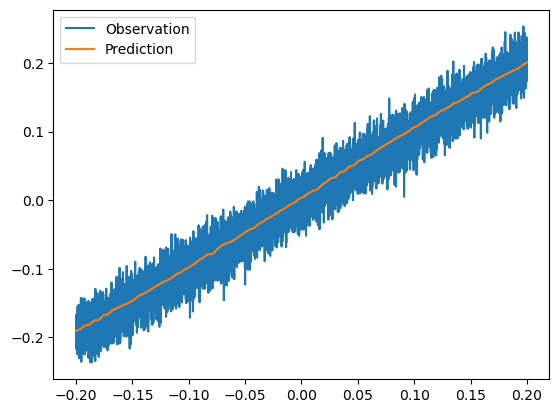

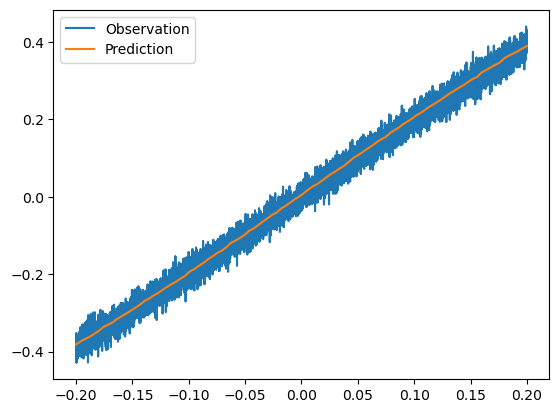

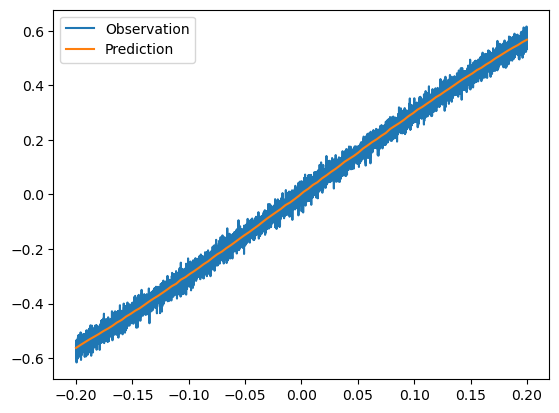

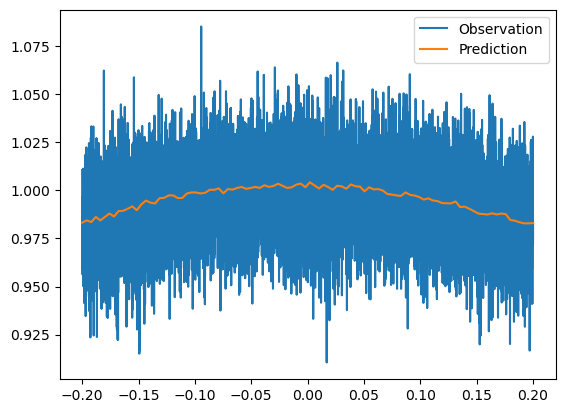

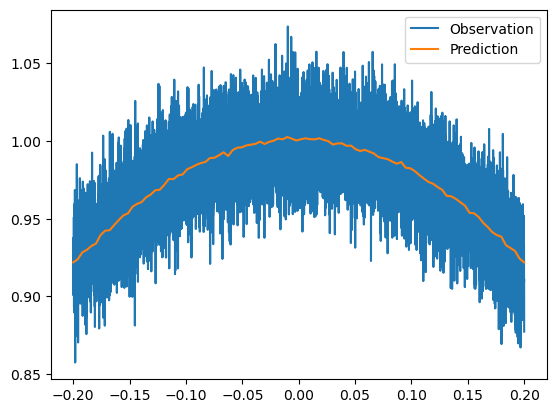

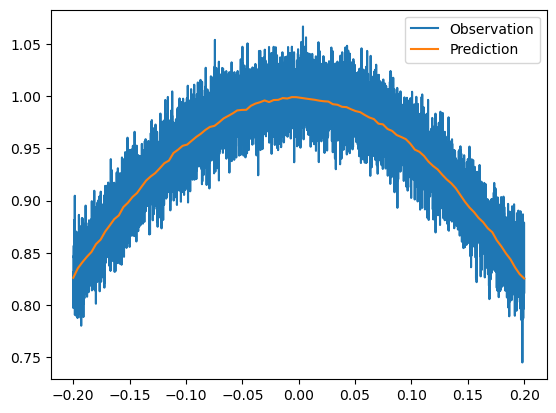

In [22]:
for d in range(6):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test, y_pred[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [34]:
# sampled Omega: model.model.layers[0].layer.weight

In [ ]:
# preds['model.layers.0.layer.weight'].squeeze().mean(axis=0): Omega estimator

In [23]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

AutoDiagonalNormal.loc torch.Size([657])
AutoDiagonalNormal.scale torch.Size([657])


In [ ]:
1 -> 50; 100 -> 6

In [ ]:
Omega 1*50  1*50
W     6*100 6*100
bias  6     6
sigma 1     1

In [ ]:
# def model(data):
#   alpha = torch.tensor(6.0)
#   beta = torch.tensor(10.0)
#   pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand(3).independent(1))
#   normalized_pay_probs = pay_probs / torch.sum(pay_probs)

#   with pyro.iarange('data_loop', len(data)):
#     pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)

In [ ]:
# def guide(data):
#   alphas = pyro.param('alphas', torch.tensor(6.).expand(3), constraint=constraints.positive)
#   betas = pyro.param('betas', torch.tensor(10.).expand(3), constraint=constraints.positive) 

#   pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1))